In [ ]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.io_utils import load_multiple_res
from utils.utils import get_path
from utils.pd_utils import get_persistent_feature_id, get_persistent_cycle, compute_outlier_scores
from utils.toydata_utils import get_toy_data
from utils.fig_utils import full_dist_to_color, all_full_dists, dist_to_color, full_dist_to_print, plot_edges_on_scatter
from vis_utils.plot import plot_scatter
from vis_utils.utils import load_dict
from persim import plot_diagrams
import os
import numpy as np
from sklearn.decomposition import PCA
import pickle

In [2]:
style_file = "utils.style"
plt.style.use(style_file)

In [3]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

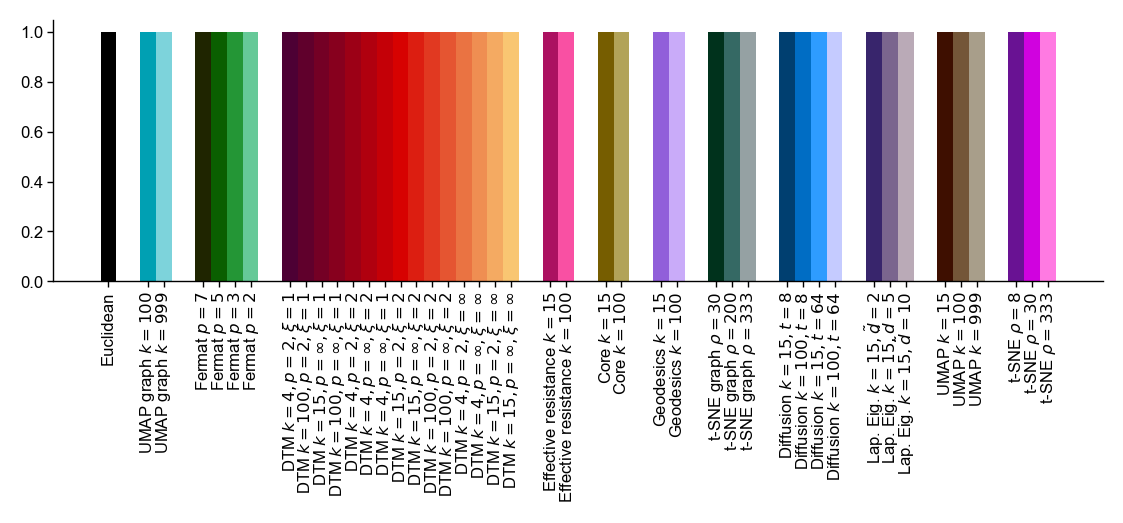

In [4]:
# show all colors
fig, ax = plt.subplots(figsize=(5.5, 2.5))
y = np.ones_like(len(full_dist_to_color))


bar_width = 0.2
sep = 1.5 * bar_width

x_vals = [0]
dist_strs = []
for i, (distance, dist_kwargs) in enumerate(all_full_dists.items()):
    x_val = x_vals[-1] + sep
    for j, full_dist in enumerate(all_full_dists[distance]):
        x_val += bar_width
        x_vals.append(x_val)
        dist_strs.append(full_dist)
        ax.bar(x_val, 1, bar_width, label=full_dist, color = full_dist_to_color[full_dist])
ax.set_xticks(x_vals[1:])
_ = ax.set_xticklabels([full_dist_to_print[dist_str].replace("\n", " ") for dist_str in dist_strs], rotation=90)
#ax.set_xticklabels(dist_strs, rotation=90)
fig.savefig(os.path.join(fig_path, "all_colors.pdf"))

# Figure 1

In [5]:
distances = {
    "euclidean": [{}],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 100, "disconnect":True},
        ]
}
embd_dim = 50
sigma = 0.25
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]
n = 1000
seed = 1

In [6]:
# load runs for toy sphere with euclidean and eff res setting
all_res = load_multiple_res(datasets="toy_circle", distances=distances, root_path=root_path, n=n, embd_dims=embd_dim, sigmas=sigmas, seeds=seeds, n_threads=10)

res_eucl = all_res["euclidean"]["euclidean"][sigma]
res_eff = all_res["eff_res"]["eff_res_corrected_True_weighted_False_k_100_disconnect_True"][sigma]

# compute outlier scores
outlier_scores = compute_outlier_scores(dgms=all_res, n_features=1, dim=1)
outlier_scores_eucl = outlier_scores["euclidean"]["euclidean"]
outlier_scores_eff = outlier_scores["eff_res"]["eff_res_corrected_True_weighted_False_k_100_disconnect_True"]

# load circle data
data_circle = np.array([get_toy_data(dataset="toy_circle", n=n, gaussian={"sigma":sigma}, seed=seed) for seed in seeds] )


# load UMAP and tSNE
umap_file_name = f"umap_n_1000_d_50_ortho_gauss_sigma_{sigma}_k_15_metric_euclidean_epochs_750_seed_{seed}_min_dist_0.1_init_pca.pkl"
with open(os.path.join(root_path, "toy_circle", umap_file_name), "rb") as f:
    umapper = pickle.load(f)
umap_embd = umapper.embedding_

tsne_file_name = f"tsne_n_1000_d_50_ortho_gauss_sigma_{sigma}_perplexity_30_n_epochs_500_n_early_epochs_250_seed_{seed}_init_pca_rescale_True.pkl"

tsne_data = load_dict(os.path.join(root_path, "toy_circle", tsne_file_name))
tsne_embd = tsne_data["embds"][-1]

Done with toy_circle 50 euclidean n_outliers=0
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0


In [ ]:
# plot figure
mosaic = """
aabd
aabd
aabd
aacd
efcd
efcd
"""
fig, ax_dict = plt.subplot_mosaic(mosaic,
                                  height_ratios=(1, 1, 1, 1, 1, 1),
                                  width_ratios = (0.9, 0.9, 0.8, 1.5),
                                  figsize=(5.5, 2.),
                                  )

fig.get_layout_engine().set(w_pad=4 / 72, h_pad=0, hspace=0.02,
                            wspace=0.02)

# panel a)
## plot ring
pca = PCA(2).fit_transform(data_circle[seed])
mask = pca[:, 1] < pca[:, 1].max()
plot_scatter(ax=ax_dict["a"], x=pca[mask], s=2, y="k", scalebar=False, alpha=1.0)
ax_dict["a"].set_title(f"Representative loops on 2D PCA\n", pad=3)


ax_dict["a"].text(
    0.1,
    1.02,
    "a\n",
        transform=ax_dict["a"].transAxes,
    ha="left",
    va="bottom",
    fontweight="bold",
    fontsize=7
)

## plot loops
pca = PCA(2).fit_transform(data_circle[seed])@ np.array([[1, 0], [0, -1]]) # mirror for nicer figure layout
loop_eucl = get_persistent_cycle(res_eucl[seed], m=1, dim=1, mode="additive")
loop_eff = get_persistent_cycle(res_eff[seed], m=1, dim=1, mode="additive")
plot_edges_on_scatter(ax=ax_dict["a"], x=pca, edge_idx=loop_eucl, color=dist_to_color["euclidean"], linewidth=1)
plot_edges_on_scatter(ax=ax_dict["a"], x=pca, edge_idx=loop_eff, color=dist_to_color["eff_res"], linewidth=1)




# panel b (persistences)
loop_id_eucl = get_persistent_feature_id(res_eucl[seed], m=1, dim=1, mode="additive")
loop_id_eff = get_persistent_feature_id(res_eff[seed], m=1, dim=1, mode="additive")

plot_diagrams(res_eucl[seed]["dgms"], ax=ax_dict["b"], plot_only=[1], size=4, color=dist_to_color["euclidean"], colormap=style_file)
ax_dict["b"].scatter(*res_eucl[seed]["dgms"][1][loop_id_eucl].T, marker = "x", color=dist_to_color["euclidean"], s=5)
ax_dict["b"].legend().set_visible(False)

ax_dict["b"].set_title("Persistence\n$\sigma = 0.25$")
ax_dict["b"].set_title(
    "b\n",
    ha="right",
    loc="left",
    fontweight="bold",
)
ax_dict["b"].set_xlabel("")
ax_dict["b"].set_xticklabels("")
ax_dict["b"].set_xticks([])
ax_dict["b"].set_yticklabels("")
ax_dict["b"].set_yticks([])

text = ax_dict["b"].text(s="Euclidean",
                  x=0.4,
                  y=0.1,
                transform=ax_dict["b"].transAxes,)

# arrows to representatives
annot1 = plt.Annotation(
    "",
    xy=(1.2, 0.8), 
    xycoords=ax_dict["a"].transData,
    xytext=(res_eucl[seed]["dgms"][1][loop_id_eucl]), 
    textcoords=ax_dict["b"].transData,
    arrowprops=dict(arrowstyle="->", linewidth=0.5, connectionstyle="angle3,angleA=80,angleB=10"),
)
ax_dict["b"].add_artist(annot1)

annot2 = plt.Annotation(
    "",
    xy=(1.7, -0.32), 
    xycoords=ax_dict["a"].transData,
    xytext=(res_eff[seed]["dgms"][1][loop_id_eff]), 
    textcoords=ax_dict["c"].transData,
    arrowprops=dict(arrowstyle="->", 
                    linewidth=0.5,
                    connectionstyle="angle3,angleA=-90,angleB=-10", 
                    color=dist_to_color["eff_res"]),
)
ax_dict["c"].add_artist(annot2)


# panel b bottom: PD for eff res
plot_diagrams(res_eff[seed]["dgms"],
              ax=ax_dict["c"],
              plot_only=[1], 
              size=4, 
              color=dist_to_color["eff_res"], 
              colormap=style_file # necessary bc plot_diagrams uses the colormap as mpl style
              )
ax_dict["c"].scatter(*res_eff[seed]["dgms"][1][loop_id_eff].T,
                     marker = "x", 
                     color=dist_to_color["eff_res"],
                     s=5)
ax_dict["c"].legend().set_visible(False)

ax_dict["c"].set_xticklabels("")
ax_dict["c"].set_xticks([])
ax_dict["c"].set_yticklabels("")
ax_dict["c"].set_yticks([])

ax_dict["c"].text(
    s="Effective\nresistance",
    x=0.4,
    y=0.1,
    c=dist_to_color["eff_res"],
    transform=ax_dict["c"].transAxes,
)


# plot outlier scores in panel c
ax_dict["d"].plot(sigmas, outlier_scores_eucl.mean(1), color="k", label="Euclidean")
ax_dict["d"].fill_between(sigmas, 
                          outlier_scores_eucl.mean(1)+outlier_scores_eucl.std(1), 
                          outlier_scores_eucl.mean(1)-outlier_scores_eucl.std(1), 
                          color="k",
                          alpha=0.2,
                          edgecolor=None,
                          clip_on=False)
ax_dict["d"].plot(sigmas, outlier_scores_eff.mean(1), color=dist_to_color["eff_res"], label="Effective\nresistance")
ax_dict["d"].fill_between(sigmas, 
                          outlier_scores_eff.mean(1)+outlier_scores_eff.std(1), 
                          outlier_scores_eff.mean(1)-outlier_scores_eff.std(1), 
                          color=dist_to_color["eff_res"],
                          alpha=0.2,
                          edgecolor=None,
                          clip_on=False)

ax_dict["d"].set_ylim(0.0, 1.0)
ax_dict["d"].set_xlim(0.0, 0.35)
ax_dict["d"].legend(loc="lower left", frameon=False)
ax_dict["d"].set_ylabel("Loop detection score")
ax_dict["d"].set_xlabel(r"Noise std $\sigma$")
ax_dict["d"].set_title(
    "c\n",
    loc="left",
    fontweight="bold",
    ha="right",
)
ax_dict["d"].set_title("Loop detection\n")

ax_dict["d"].axvline(sigma, linestyle="dotted", c="k")
ax_dict["d"].set_xticks([0.0, 0.1, 0.2, 0.25, 0.3])
ax_dict["d"].set_xticklabels([0.0, 0.1, 0.2, 0.25, 0.3])


# panel d UMAP
plot_scatter(ax=ax_dict["e"], x=umap_embd, s=2, y="k", scalebar=False, alpha=1.0)
ax_dict["e"].set_title("UMAP")
ax_dict["e"].text(
    0.2,
    1.02,
    "d",
    transform=ax_dict["e"].transAxes,
    ha="left",
    va="bottom",
    fontweight="bold",
    fontsize=7
)


# panel e tSNE
plot_scatter(ax=ax_dict["f"], x=tsne_embd, s=2, y="k", scalebar=False, alpha=1.0)
ax_dict["f"].set_title("t-SNE")
ax_dict["f"].text(
    0.2,
    1.02,
    "e",
    transform=ax_dict["f"].transAxes,
    ha="left",
    va="bottom",
    fontweight="bold",
    fontsize=7
)

fig.savefig(os.path.join(fig_path, f"fig_1.pdf"))